In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import load_img
from tensorflow.keras import Sequential
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
directory= 'pcos-datasets/training'
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=True,
    crop_to_aspect_ratio=False,
)

Found 4022 files belonging to 2 classes.


In [3]:
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30,
                             validation_split=0.3,
                             fill_mode='nearest'
                             )
train = datagen.flow_from_directory( directory, 
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       subset='training')
valid = datagen.flow_from_directory( directory, 
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       subset='validation')

Found 2816 images belonging to 2 classes.
Found 1206 images belonging to 2 classes.


In [4]:
model = Sequential()
model.add(Conv2D(15, (5,5),padding='valid',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Conv2D(12, (4,4),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(8, (3,3),padding='valid',activation='relu'))
model.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

c:\Users\roboc\anaconda3\envs\tf-cuda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 15)   │         1,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 44, 44, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 41, 41, 12)     │         2,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 8)        │           872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,642 (381.41 KB)

 Trainable params: 97,642 (381.41 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adam', loss=BinaryCrossentropy(reduction='none'), metrics=['accuracy'])

In [7]:
class EarlyStoppingAtHighAccuracy(Callback):
  def __init__(self, patience=0, min_delta=0., threshold=0.99):
    super(EarlyStoppingAtHighAccuracy, self).__init__()
    self.patience = patience
    self.min_delta = min_delta
    self.threshold = threshold
    self.wait = 0
    self.best_val_acc = 0.0

  def on_epoch_end(self, epoch, logs=None):
    val_acc = logs.get('val_accuracy')
    current_val_acc = max(self.best_val_acc, val_acc) 

    if current_val_acc >= self.threshold:
      self.wait = 0
      self.best_val_acc = current_val_acc
      print(f"Validation Accuracy reached {current_val_acc:.4f} (threshold: {self.threshold:.4f}) - Stopping training early!")
      self.model.stop_training = True
    elif val_acc + self.min_delta < self.best_val_acc:
      self.wait += 1
      if self.wait > self.patience:
        print(f"Validation Accuracy did not improve for {self.wait} epochs - Stopping training early!")
        self.model.stop_training = True

In [8]:
early_stopping = EarlyStoppingAtHighAccuracy(patience=3, min_delta=0.001)

In [9]:
history = model.fit(train,validation_data=valid,epochs=100, callbacks=[early_stopping])

Epoch 1/100


c:\Users\roboc\anaconda3\envs\tf-cuda\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 750ms/step - accuracy: 0.5301 - loss: 0.6573 - val_accuracy: 0.9378 - val_loss: 0.3297
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 678ms/step - accuracy: 0.9447 - loss: 0.1916 - val_accuracy: 0.9080 - val_loss: 0.2935
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 694ms/step - accuracy: 0.9884 - loss: 0.0377 - val_accuracy: 0.9635 - val_loss: 0.1221
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 679ms/step - accuracy: 0.9916 - loss: 0.0264 - val_accuracy: 0.9320 - val_loss: 0.2368
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 677ms/step - accuracy: 0.9953 - loss: 0.0215 - val_accuracy: 0.9685 - val_loss: 0.0968
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 673ms/step - accuracy: 0.9981 - loss: 0.0095 - val_accuracy: 0.9635 - val_loss: 0.0847
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 676ms/step - accuracy: 0.9895 - loss: 0.0389 - val_accuracy: 0.9735 - val_loss: 0.1045
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 695ms/step - accuracy: 0.9945 - loss: 0.0174 - val_accuracy

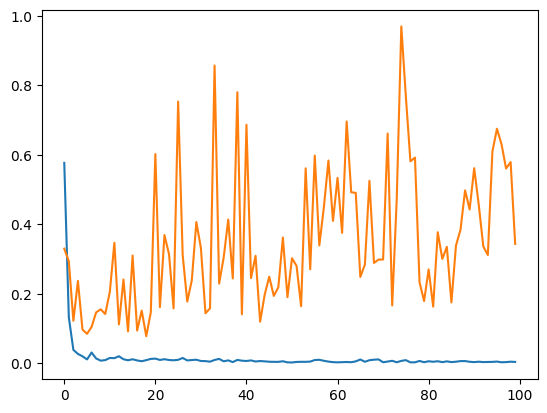

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [13]:
model.save('PCOSClassification-model-99%.h5')

In [16]:
# from tensorflow import keras
# model = keras.models.load_model('PCOSClassification-model-final.h5')
image = load_img('pcos-datasets/testing/notinfected/img_0_6902.jpg', target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
prediction = model.predict(img)
l={"infected":prediction[0][0],"notinfected":prediction[0][1]}
def get_key(val):
    for key, value in l.items():
         if val == value:
             return key
 
    return "key doesn't exist"
res=prediction.max()
get_key(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'notinfected'